In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyro.infer import HMC, NUTS
from pyro.infer.mcmc import MCMC
import pdb
from src.models import HMC_vanilla


from tqdm import tqdm
%matplotlib inline

import sys
sys.path.insert(0, './src')

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

In [5]:
class GMM():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-3., 0.], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.loc_2 = torch.tensor([3., 0.], dtype=torch.float32, device=device)
        self.covar_2 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        self.distr_2 = torch.distributions.MultivariateNormal(loc=self.loc_2, covariance_matrix=self.covar_2,)
        
        self.p = torch.tensor(0.5, dtype=torch.float32, device=device)
        self.bernoulli = torch.distributions.Bernoulli(probs=self.p)
        
    def log_prob(self, z, x=None):
        samples = z
        return torch.logsumexp(torch.cat([self.p.log() + self.distr_1.log_prob(samples)[None],
                                          (1. - self.p).log() + self.distr_2.log_prob(samples)[None]], dim=0), dim=0)
    
    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, size):
        c = self.bernoulli.sample(size)[..., None]
        return c * self.distr_1.sample(size) + (1. - c) * self.distr_2.sample(size)
    
class Gaussian():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., -2], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        
    def log_prob(self, z, x=None):
        return self.distr_1.log_prob(z)
    
    def energy_function(self, init_params):
        return -self.distr_1.log_prob(z)
    
    def sample(self, size):
        return self.distr_1.sample(size)

In [6]:
target = GMM(device=device)

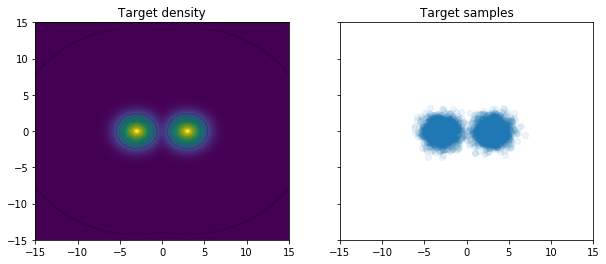

In [7]:
x_lim = 15
y_lim = 15
npts = 500

xside = np.linspace(-x_lim - 1, x_lim + 1, npts)
yside = np.linspace(-y_lim - 1, y_lim + 1, npts)
xx, yy = np.meshgrid(xside, yside)
z = torch.tensor(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]), device=device, dtype=torch.float32)
logdens = target.log_prob(z)
p = np.exp(logdens.cpu().detach().numpy().reshape(npts, npts))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].set_title('Target density')
ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))
ax[0].contour(xx, yy, p, 15, colors='black', alpha=0.2);
ax[0].set_xlim(-x_lim, x_lim)
ax[0].set_ylim(0, y_lim)
ax[0].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[0].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

ax[1].set_title('Target samples')
samples = target.sample((5000, )).cpu().detach().numpy()
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.075)
ax[1].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[1].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

In [8]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['N'] = 5
args['alpha'] = 0.5
args['gamma'] = 1.
args['use_partialref'] = False
args['use_barker'] = False

In [9]:
def compute_KL(z, mu, std, target):
    KL = torch.distributions.Normal(loc=mu, scale=std).log_prob(z).mean() - target.log_prob(z).mean()
    return KL

def VCD(z, mu, std, target, control_variate):
    first_term = compute_KL(z, mu, std, target)
    z_mcmc = run_mcmc(z.detach())
    second_aux = -compute_KL(z_mcmc, mu, std, target).detach()
    second_term = -torch.distributions.Normal(loc=mu, scale=std).log_prob(z_mcmc).mean() + (second_aux - control_variate) * torch.distributions.Normal(loc=mu, scale=std).log_prob(z).mean()
    control_variate = gamma_ma * control_variate + (1. - gamma_ma) * second_aux
    vcd = first_term + second_term
    return vcd, control_variate, z_mcmc

def run_mcmc_pyro(z):
    z_mcmc = torch.tensor([], device=device, dtype=torch.float32)
    for i in range(z.shape[0]):
        init_samples = z[i]
        init_params = {'points': init_samples}
        mcmc = MCMC(kernel=kernel, num_samples=1, warmup_steps=5, initial_params=init_params, disable_progbar=True)
        mcmc.run()
        z_mcmc = torch.cat([z_mcmc, mcmc._samples['points'].squeeze()[None]], dim=0)
    return z_mcmc

def run_mcmc(z):
    z_mcmc = z
    gamma = args.gamma
    for i in range(L):
        z_mcmc, _, _ = transition.make_transition(z_mcmc, None, target)
    return z_mcmc

In [10]:
batch_size = 100
n_batches = 2001
lr = 0.01

control_variate = 0.
gamma_ma = 0.9  # moving average

kernel = HMC(potential_fn=target.energy_function, num_steps=5,)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=device),
                                       scale=torch.tensor(1., dtype=torch.float32, device=device))

## Forward KL

In [11]:
set_seeds(111)

In [12]:
mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
params = [mu, logvar]
optimizer = torch.optim.RMSprop(params=params, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

  0%|          | 0/2001 [00:00<?, ?it/s]

kl is 3.882824420928955
mu is [0.09999711 0.09999855]
logvar is [ 0.09999999 -0.09999996]


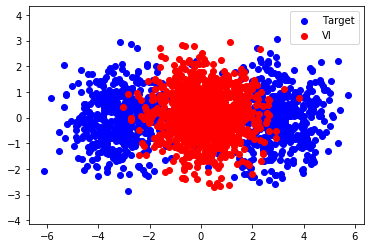

  3%|▎         | 61/2001 [00:00<00:46, 41.81it/s]

kl is 2.6378021240234375
mu is [1.9462587 0.0082331]
logvar is [ 1.0638746  -0.71426225]


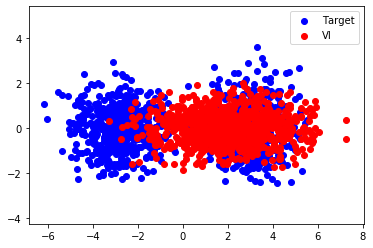

  8%|▊         | 158/2001 [00:00<00:24, 76.45it/s]

kl is 2.07920241355896
mu is [2.836733   0.03323986]
logvar is [ 0.11198375 -0.7155314 ]


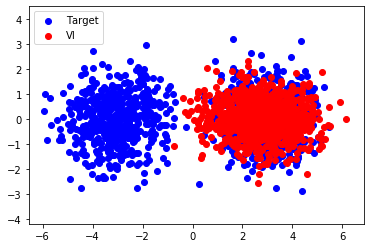

 13%|█▎        | 258/2001 [00:00<00:13, 128.68it/s]

kl is 1.9556427001953125
mu is [ 3.0250084  -0.05680784]
logvar is [-0.4312605  -0.72744167]


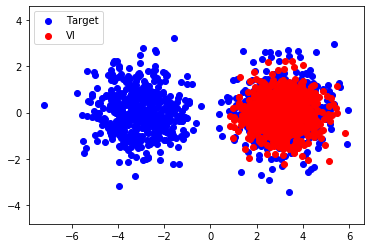

 18%|█▊        | 358/2001 [00:00<00:08, 194.39it/s]

kl is 1.9558730125427246
mu is [ 2.9870923  -0.00734924]
logvar is [-0.6187365 -0.7034738]


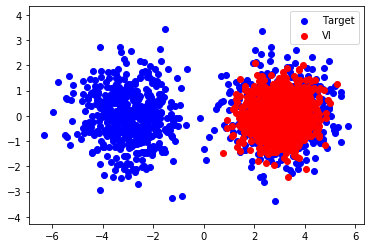

 23%|██▎       | 458/2001 [00:01<00:05, 258.19it/s]

kl is 1.9561104774475098
mu is [3.0106323  0.02131712]
logvar is [-0.6672617 -0.7465308]


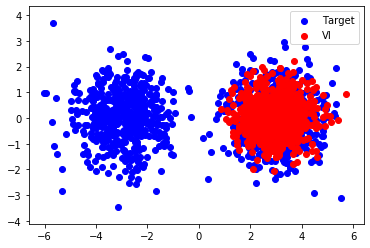

 28%|██▊       | 558/2001 [00:01<00:04, 307.59it/s]

kl is 1.9583117961883545
mu is [3.0012183  0.03217451]
logvar is [-0.694413  -0.6881959]


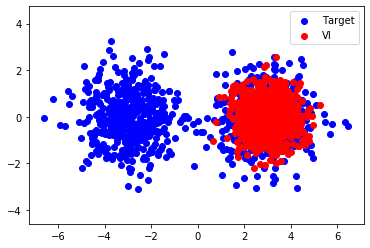

 33%|███▎      | 660/2001 [00:01<00:03, 344.04it/s]

kl is 1.9584192037582397
mu is [2.9503722e+00 5.5805530e-04]
logvar is [-0.6811202  -0.68048996]


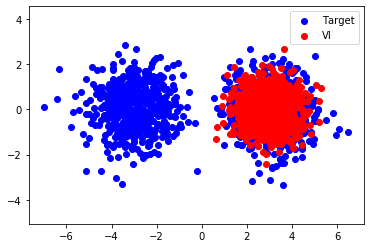

 38%|███▊      | 761/2001 [00:02<00:03, 364.73it/s]

kl is 1.959015965461731
mu is [2.9923196  0.00678646]
logvar is [-0.69356656 -0.6981395 ]


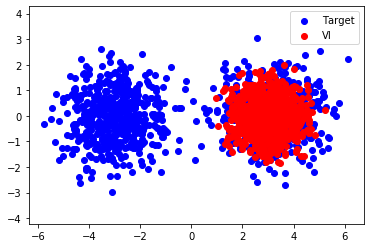

 43%|████▎     | 863/2001 [00:02<00:03, 373.55it/s]

kl is 1.9585703611373901
mu is [ 2.967629   -0.02291287]
logvar is [-0.71321064 -0.6917569 ]


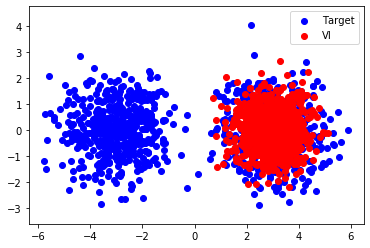

 48%|████▊     | 965/2001 [00:02<00:02, 379.01it/s]

kl is 1.9591301679611206
mu is [2.9824328  0.00456581]
logvar is [-0.6868221 -0.6961027]


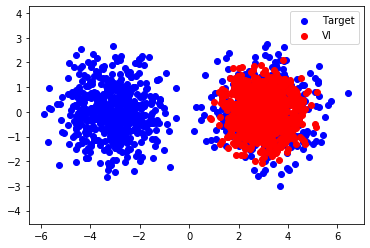

 53%|█████▎    | 1068/2001 [00:02<00:02, 381.22it/s]

kl is 1.9606016874313354
mu is [ 3.0001004e+00 -1.3748265e-04]
logvar is [-0.6883946 -0.6685691]


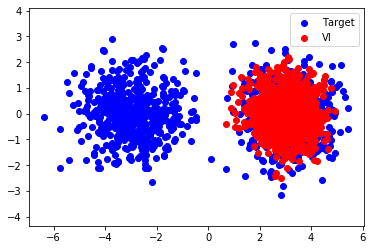

 58%|█████▊    | 1170/2001 [00:03<00:02, 362.82it/s]

kl is 1.9622139930725098
mu is [3.008757   0.00783334]
logvar is [-0.60343784 -0.6892007 ]


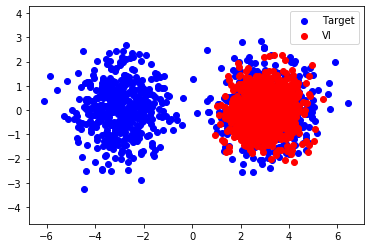

 64%|██████▎   | 1272/2001 [00:03<00:01, 371.95it/s]

kl is 1.9597769975662231
mu is [ 3.0080168  -0.00361944]
logvar is [-0.699626   -0.76570874]


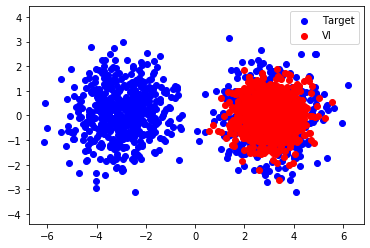

 69%|██████▊   | 1374/2001 [00:03<00:01, 377.96it/s]

kl is 1.9591970443725586
mu is [ 3.0012558e+00 -1.8539160e-03]
logvar is [-0.6916432 -0.6918222]


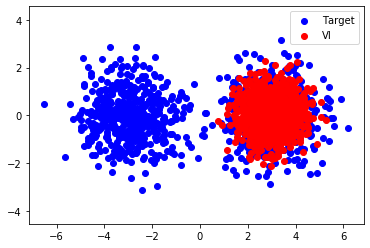

 74%|███████▍  | 1477/2001 [00:03<00:01, 386.60it/s]

kl is 1.9592515230178833
mu is [ 2.9844148 -0.0152658]
logvar is [-0.69454783 -0.71428096]


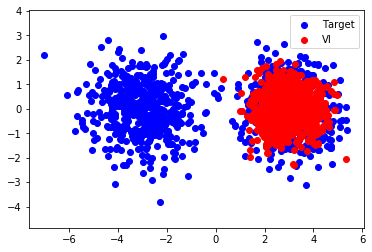

 79%|███████▉  | 1580/2001 [00:04<00:01, 387.00it/s]

kl is 1.957411527633667
mu is [ 2.967295  -0.0107293]
logvar is [-0.70507026 -0.7453525 ]


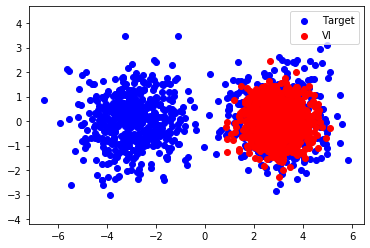

 84%|████████▍ | 1683/2001 [00:04<00:00, 387.02it/s]

kl is 1.9548423290252686
mu is [2.994661   0.04234239]
logvar is [-0.7598005 -0.6551399]


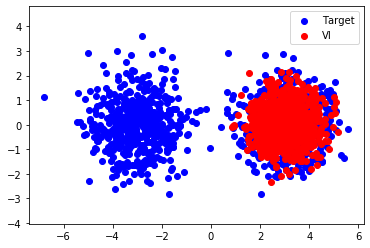

 89%|████████▉ | 1786/2001 [00:04<00:00, 387.12it/s]

kl is 1.9610484838485718
mu is [3.0218122  0.00502437]
logvar is [-0.7082288  -0.76912194]


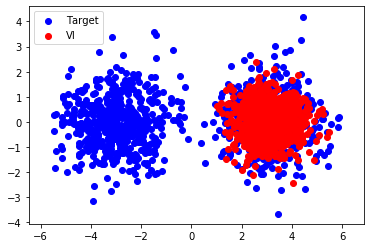

 94%|█████████▍| 1889/2001 [00:05<00:00, 385.38it/s]

kl is 1.9628174304962158
mu is [3.005657   0.00578819]
logvar is [-0.6934868 -0.6968119]


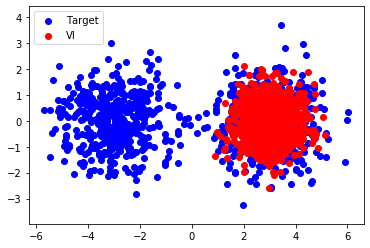

100%|█████████▉| 1992/2001 [00:05<00:00, 385.60it/s]

kl is 1.9620351791381836
mu is [3.0146236e+00 3.3426466e-05]
logvar is [-0.7050292 -0.6829065]


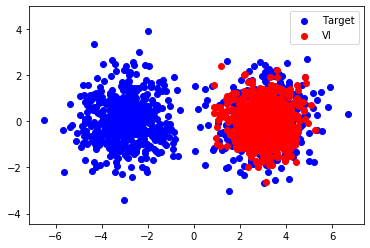

100%|██████████| 2001/2001 [00:05<00:00, 366.45it/s]


In [13]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    eps = std_normal.sample((batch_size, 2))
    std = torch.exp(logvar * 0.5)
    z = mu + eps * std
    kl = compute_KL(z, mu, std, target)
    kl.backward()
    optimizer.step()
    optimizer.zero_grad()
#     scheduler.step()
    with torch.no_grad():
        if b_num % 100 == 0:
            print(f'kl is {kl.cpu().detach().item()}')
            print(f'mu is {mu.cpu().detach().numpy()}')
            print(f'logvar is {logvar.cpu().detach().numpy()}')
            std = torch.exp(0.5 * logvar)
            samples_target = target.sample((1000, )).cpu().detach().numpy()
            samples_vi = (mu + std_normal.sample((1000, 2)) * std).cpu().detach().numpy()
            plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
            plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
            plt.legend()
            plt.axis('equal')
            plt.show()

## VCD

In [14]:
set_seeds(111)

In [15]:
L = 20
transition = HMC_vanilla(args)

#### MCMC validation

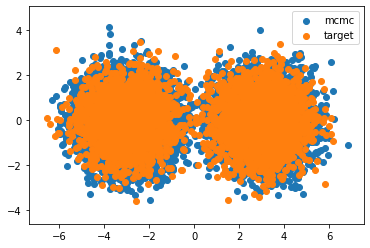

In [16]:
samples_mcmc = run_mcmc(torch.randn(10000, 2).to(torch.device("cuda:0"))).cpu().numpy()
samples_target = target.sample((samples.shape[0], )).cpu().numpy()
plt.scatter(samples_mcmc[:, 0], samples_mcmc[:, 1], label='mcmc')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='target')
plt.axis('equal')
plt.legend();

In [17]:
control_variate = 0.

mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
params = [mu, logvar]
optimizer = torch.optim.RMSprop(params=params, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

  0%|          | 0/2001 [00:00<?, ?it/s]

mu is [-0.09999961 -0.09999989]
logvar is [ 0.09999999 -0.09999995]
control_variate if 0.011511683464050293


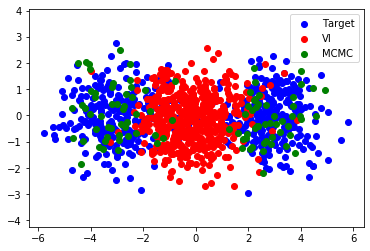

  5%|▍         | 100/2001 [00:17<05:22,  5.89it/s]

mu is [-1.52055    -0.00491873]
logvar is [ 1.3819659  -0.35415763]
control_variate if -1.404378890991211


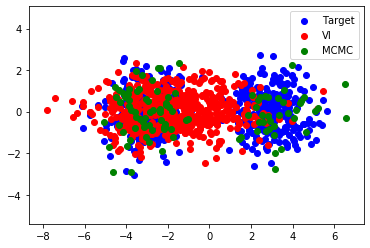

 10%|▉         | 200/2001 [00:33<04:53,  6.15it/s]

mu is [-1.4148914   0.00264531]
logvar is [ 1.6563402  -0.33253512]
control_variate if -1.4879240989685059


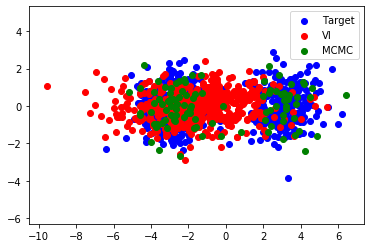

 15%|█▍        | 300/2001 [00:50<04:42,  6.01it/s]

mu is [-0.8245643   0.00113059]
logvar is [ 1.8720481  -0.36047828]
control_variate if -1.4779119491577148


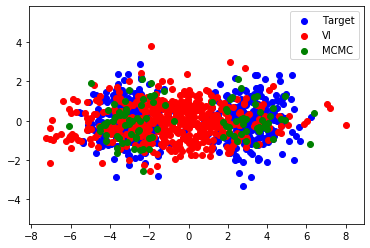

 20%|█▉        | 400/2001 [01:07<04:29,  5.94it/s]

mu is [-0.42577872 -0.02343884]
logvar is [ 1.9546083  -0.32352516]
control_variate if -1.5492099523544312


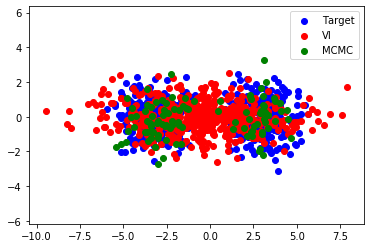

 25%|██▍       | 500/2001 [01:24<04:15,  5.88it/s]

mu is [-0.22503601  0.02215882]
logvar is [ 1.9436395 -0.3403459]
control_variate if -1.5287925004959106


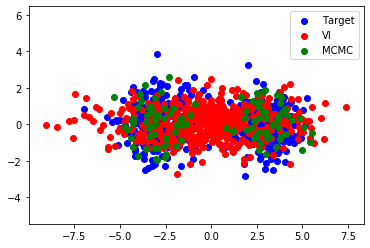

 30%|██▉       | 600/2001 [01:41<04:00,  5.82it/s]

mu is [-0.10729477 -0.01656478]
logvar is [ 1.9948817  -0.32884365]
control_variate if -1.5125125646591187


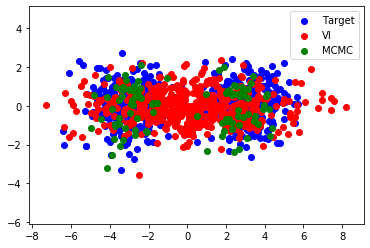

 35%|███▍      | 700/2001 [01:57<03:34,  6.06it/s]

mu is [-0.00874147 -0.00527014]
logvar is [ 1.9476347  -0.32605404]
control_variate if -1.5069777965545654


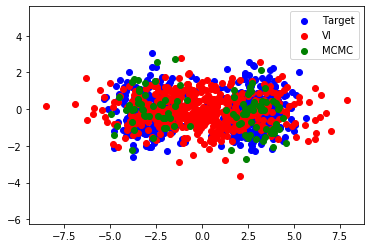

 40%|███▉      | 800/2001 [02:14<03:20,  6.00it/s]

mu is [ 0.0266548  -0.01343547]
logvar is [ 1.9308825  -0.38865587]
control_variate if -1.4788209199905396


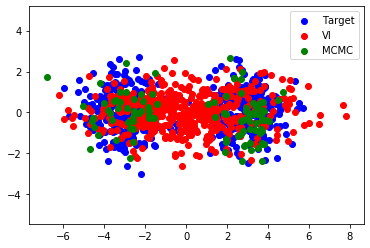

 45%|████▍     | 900/2001 [02:31<03:06,  5.92it/s]

mu is [ 0.04729752 -0.00624193]
logvar is [ 1.9774249  -0.35031572]
control_variate if -1.513094425201416


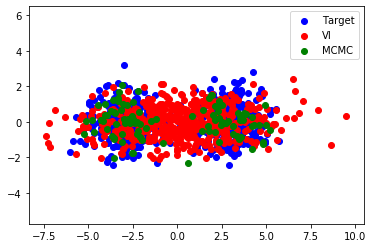

 50%|████▉     | 1000/2001 [02:48<02:40,  6.24it/s]

mu is [-0.03225628 -0.01578112]
logvar is [ 1.9464988 -0.32999  ]
control_variate if -1.5303809642791748


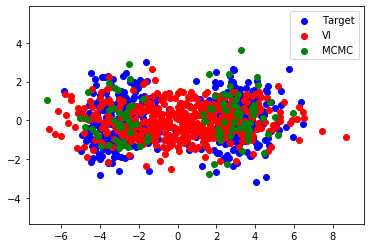

 55%|█████▍    | 1100/2001 [03:04<02:24,  6.23it/s]

mu is [-0.12627023 -0.01126964]
logvar is [ 1.9371315  -0.34252998]
control_variate if -1.5121864080429077


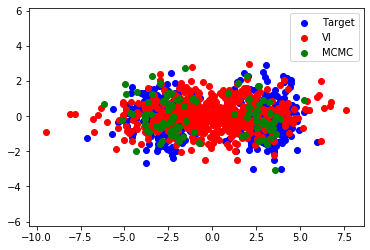

 60%|█████▉    | 1200/2001 [03:20<02:13,  6.00it/s]

mu is [-0.11489884  0.00139995]
logvar is [ 1.892849  -0.3625895]
control_variate if -1.5206836462020874


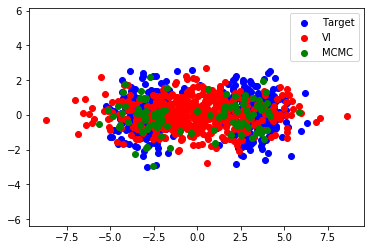

 65%|██████▍   | 1300/2001 [03:37<01:57,  5.98it/s]

mu is [-0.07448836  0.00245979]
logvar is [ 1.9414    -0.3440097]
control_variate if -1.488046646118164


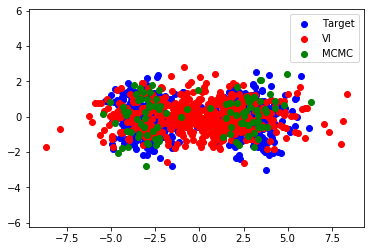

 70%|██████▉   | 1400/2001 [03:54<01:41,  5.92it/s]

mu is [-0.04325805 -0.00026899]
logvar is [ 1.9701388  -0.33369863]
control_variate if -1.5518687963485718


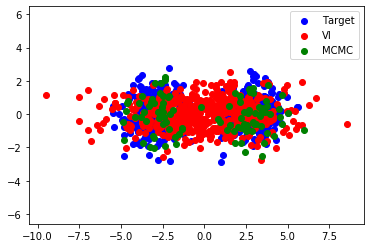

 75%|███████▍  | 1500/2001 [04:11<01:25,  5.87it/s]

mu is [-0.03999788  0.00446065]
logvar is [ 1.9174616  -0.29784128]
control_variate if -1.5365705490112305


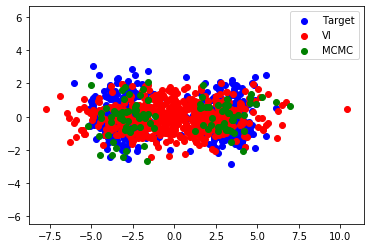

 80%|███████▉  | 1600/2001 [04:27<01:07,  5.98it/s]

mu is [0.04427601 0.01882107]
logvar is [ 1.9936244  -0.33070508]
control_variate if -1.5306273698806763


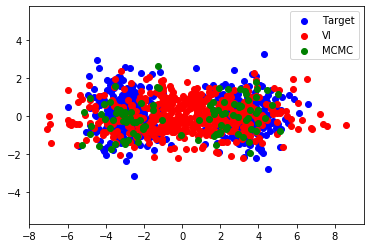

 85%|████████▍ | 1700/2001 [04:44<00:51,  5.87it/s]

mu is [-0.01436795  0.0414592 ]
logvar is [ 1.9680496 -0.3342567]
control_variate if -1.5209215879440308


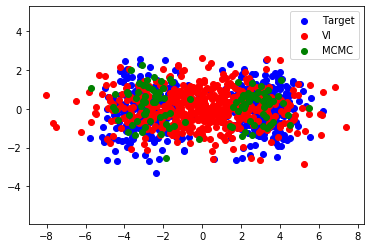

 90%|████████▉ | 1800/2001 [05:01<00:32,  6.14it/s]

mu is [0.01648678 0.01029865]
logvar is [ 1.9210408  -0.33864862]
control_variate if -1.5197069644927979


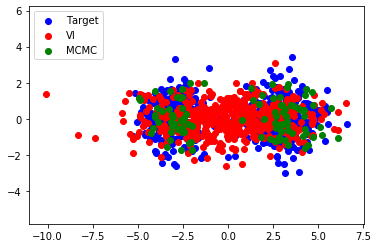

 95%|█████████▍| 1900/2001 [05:17<00:16,  6.14it/s]

mu is [-0.01644814  0.02239537]
logvar is [ 1.967151   -0.33437225]
control_variate if -1.497252106666565


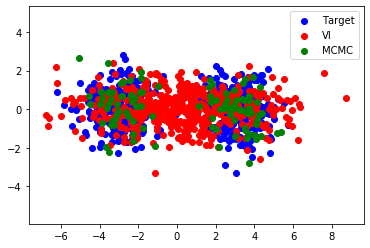

100%|█████████▉| 2000/2001 [05:34<00:00,  6.12it/s]

mu is [-0.01610421 -0.01401607]
logvar is [ 1.939628 -0.356561]
control_variate if -1.5130099058151245


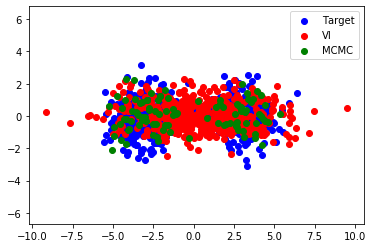

100%|██████████| 2001/2001 [05:34<00:00,  5.98it/s]


In [18]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    batch = target.sample((batch_size, ))
    eps = std_normal.sample(batch.shape)
    std = torch.exp(logvar * 0.5)
    z = mu + eps * std
    vcd, control_variate, z_mcmc = VCD(z, mu, std, target, control_variate)
    vcd.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        if b_num % 100 == 0:
            print(f'mu is {mu.cpu().detach().numpy()}')
            print(f'logvar is {logvar.cpu().detach().numpy()}')
            print(f'control_variate is {control_variate}')
            samples_target = target.sample((z_mcmc.shape[0] * 5, )).cpu().detach().numpy()
            z_mcmc = z_mcmc.cpu().numpy()
            samples_vi = (mu + std_normal.sample((z_mcmc.shape[0] * 5, 2)) * torch.exp(0.5 * logvar)).cpu().detach().numpy()
            plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
            plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
            plt.scatter(z_mcmc[:, 0], z_mcmc[:, 1], label='MCMC', c='g')
            plt.legend()
            plt.axis('equal')
            plt.show()

## Visualisation of final samples

In [21]:
n_samples = 1000

In [22]:
mu_vcd = mu.detach()
logvar_vcd = logvar.detach()

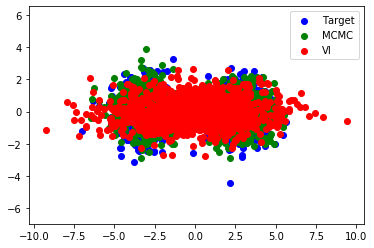

In [25]:
batch = target.sample((n_samples, ))
eps = std_normal.sample(batch.shape)
z = mu_vcd + eps * torch.exp(logvar_vcd * 0.5)
mcmc = run_mcmc(z.detach())
samples_target = batch.cpu().detach().numpy()
samples_vi = z_vcd.cpu().detach().numpy()
z = z.cpu().detach().numpy()
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='MCMC', c='g')
plt.scatter(z[:, 0], z[:, 1], label='VI', c='r')
plt.legend()
plt.axis('equal')
plt.show()